In [1]:
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload complete

In [2]:
from math import ceil
from functools import partial
from pathlib import Path
import datetime

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import dask
import cftime

from project.io import IntakeESMLoader, save_mfdataset
from project.plotting import plot_field
from project.util import stack_state, unstack_state, is_dask_array, get_data_path
from project.eof import EOF, EOFXArray, EOFMethod
from project.spaces import PhysicalSpaceForecastSpaceMapper, Detrend, NanMask

In [3]:
ds = xr.open_dataset("/home/enkf6/dstiller/test_io_output.nc", chunks=dict(time=1))[
    ["ohc700", "tas", "psl", "pr"]
]

/home/disk/p/dstiller/.local/software/miniconda3/envs/enspred/lib/python3.11/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/disk/p/dstiller/.local/software/miniconda3/envs/enspred/lib/python3.11/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


In [4]:
ds

<xarray.Dataset>
Dimensions:  (time: 480, lat: 90, lon: 180)
Coordinates:
  * time     (time) object 7001-01-16 12:00:00 ... 7040-12-16 12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    ohc700   (time, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    tas      (time, lat, lon) float32 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    psl      (time, lat, lon) float32 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>

In [5]:
data = ds["psl"].isel(time=slice(None, 100)).dropna("lat")
data = stack_state(data)
data -= data.mean(dim="time")
data

<xarray.DataArray '' (state: 15840, time: 100)>
dask.array<sub, shape=(15840, 100), dtype=float32, chunksize=(15840, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 7001-01-16 12:00:00 ... 7009-04-16 00:00:00
  * state    (state) object MultiIndex
  * field    (state) object 'psl' 'psl' 'psl' 'psl' ... 'psl' 'psl' 'psl' 'psl'
  * lon      (state) float64 0.0 0.0 0.0 0.0 0.0 ... 358.0 358.0 358.0 358.0
  * lat      (state) float64 -87.0 -85.0 -83.0 -81.0 ... 81.0 83.0 85.0 87.0
Attributes:
    standard_name:  air_pressure_at_mean_sea_level
    long_name:      Sea Level Pressure
    units:          Pa
    realm:          atmos
    regrid_method:  bilinear

In [6]:
eof = EOFXArray(10)
eof.fit(data, EOFMethod.DASK)

2023-12-02 17:36:50,939 DEBUG:project.eof:Calculating EOFs using Dask (rank = 10)


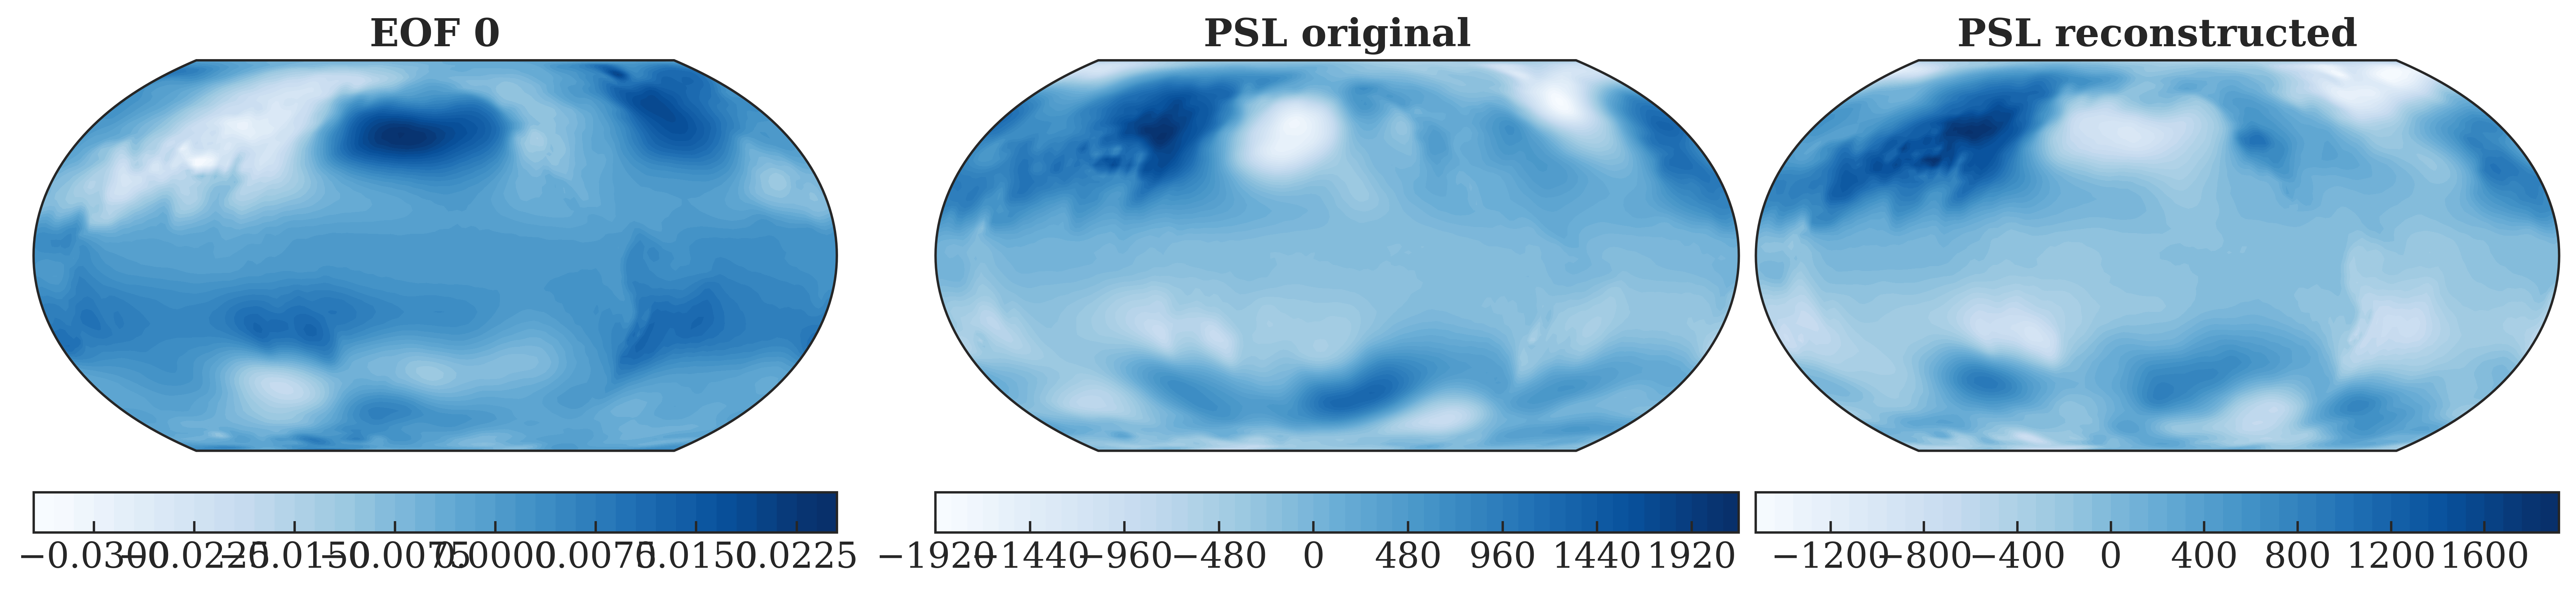

In [7]:
fig, axs = plt.subplots(
    1,
    3,
    figsize=(15, 5),
    subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=198)),
)

axs[0].set_title("EOF 0")
plot_field(axs[0], unstack_state(eof.get_component(0))["psl"].T)

axs[1].set_title("PSL original")
plot_field(axs[1], unstack_state(data.isel(time=0))["psl"].T)

axs[2].set_title("PSL reconstructed")
plot_field(
    axs[2],
    unstack_state(eof.project_backwards(eof.project_forwards(data.isel(time=0))))[
        "psl"
    ].T,
)

In [24]:
data = ds.isel(time=slice(None, 50))

mapper = PhysicalSpaceForecastSpaceMapper(10, 30, ["ohc700"], ["pr"])
mapper.fit(data)

2023-12-02 22:12:25,407 INFO:project.spaces:PhysicalSpaceForecastSpaceMapper.fit()
2023-12-02 22:12:25,408 INFO:project.spaces:Splitting dataset into Dask arrays


2023-12-02 22:12:25,458 INFO:project.spaces:Masking nans
2023-12-02 22:12:25,879 INFO:project.spaces:Calculating field variances
2023-12-02 22:12:26,480 INFO:project.spaces:Detrending data
2023-12-02 22:12:27,470 INFO:project.spaces:Standardizing pr before individual EOF
2023-12-02 22:12:27,474 INFO:project.spaces:Fitting EOF for ohc700 [1/4]
2023-12-02 22:12:27,475 DEBUG:project.eof:Calculating EOFs using Dask (rank = 10)
2023-12-02 22:12:28,045 INFO:project.spaces:Projecting EOF for ohc700
2023-12-02 22:12:28,047 INFO:project.spaces:Standardizing ohc700 after individual EOF
2023-12-02 22:12:28,052 INFO:project.spaces:Fitting EOF for tas [2/4]
2023-12-02 22:12:28,053 DEBUG:project.eof:Calculating EOFs using Dask (rank = 10)
2023-12-02 22:12:28,835 INFO:project.spaces:Projecting EOF for tas
2023-12-02 22:12:28,837 INFO:project.spaces:Standardizing tas after individual EOF
2023-12-02 22:12:28,841 INFO:project.spaces:Fitting EOF for psl [3/4]
2023-12-02 22:12:28,842 DEBUG:project.eof:Cal

In [9]:
# mapper.save(Path("/home/enkf6/dstiller/enspred/mapper"))

In [25]:
x = mapper.forward(data)
x

2023-12-02 22:12:31,787 INFO:project.spaces:PhysicalSpaceForecastSpaceMapper.forward()
2023-12-02 22:12:31,788 INFO:project.spaces:Splitting dataset into Dask arrays
2023-12-02 22:12:31,834 INFO:project.spaces:Masking nans
2023-12-02 22:12:31,845 INFO:project.spaces:Detrending data
2023-12-02 22:12:31,869 INFO:project.spaces:Standardizing pr before individual EOF
2023-12-02 22:12:31,873 INFO:project.spaces:Projecting EOF for ohc700 [1/4]
2023-12-02 22:12:31,875 INFO:project.spaces:Standardizing ohc700 after individual EOF
2023-12-02 22:12:31,880 INFO:project.spaces:Projecting EOF for tas [2/4]
2023-12-02 22:12:31,883 INFO:project.spaces:Standardizing tas after individual EOF
2023-12-02 22:12:31,887 INFO:project.spaces:Projecting EOF for psl [3/4]
2023-12-02 22:12:31,889 INFO:project.spaces:Standardizing psl after individual EOF
2023-12-02 22:12:31,894 INFO:project.spaces:Projecting EOF for pr [4/4]
2023-12-02 22:12:31,896 INFO:project.spaces:Projecting joint EOF for tas, psl, pr
2023-1

dask.array<concatenate, shape=(40, 50), dtype=float64, chunksize=(30, 1), chunktype=numpy.ndarray>

In [27]:
y = mapper.backward(x, data.time)
y

2023-12-02 22:12:46,887 INFO:project.spaces:PhysicalSpaceForecastSpaceMapper.backward()
2023-12-02 22:12:46,888 INFO:project.spaces:Splitting direct fields for ohc700


2023-12-02 22:12:46,890 INFO:project.spaces:Back-projecting joint EOF for tas, psl, pr
2023-12-02 22:12:46,897 INFO:project.spaces:De-standardizing ohc700 after individual EOF
2023-12-02 22:12:46,900 INFO:project.spaces:Back-projecting EOF for ohc700 [1/4]


ValueError: operands could not be broadcast together with shapes (9552, 50) (9552,)

In [12]:
xr.DataArray(x, coords=dict(state=np.arange(x.shape[0]), time=data.time))

<xarray.DataArray 'concatenate-dcc8cb306bd64b0e787c0bf158fc9089' (state: 40,
                                                                  time: 50)>
dask.array<concatenate, shape=(40, 50), dtype=float64, chunksize=(30, 1), chunktype=numpy.ndarray>
Coordinates:
  * state    (state) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
  * time     (time) object 7001-01-16 12:00:00 ... 7005-02-15 00:00:00

In [13]:
save_mfdataset(xr.DataArray(x, coords=dict(state=np.arange(x.shape[0]), time=data.time)).to_dataset(name="data"), get_data_path() / "training_data")

2023-12-02 17:37:21,956 INFO:project.io:Saving dataset


2023-12-02 17:37:22,537 INFO:project.io:Saved dataset to /home/enkf6/dstiller/enspred/training_data/2023-12-02T17-37-21


In [14]:
((y - data) ** 2).mean().compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    ohc700   float64 7.933e+16
    tas      float64 1.454
    psl      float64 6.361e+04
    pr       float64 1.678e-10

ValueError: The length of the coordinate does not match the size of the corresponding dimension of the data array: len(coord) = 180, data.shape[-1] = 90.

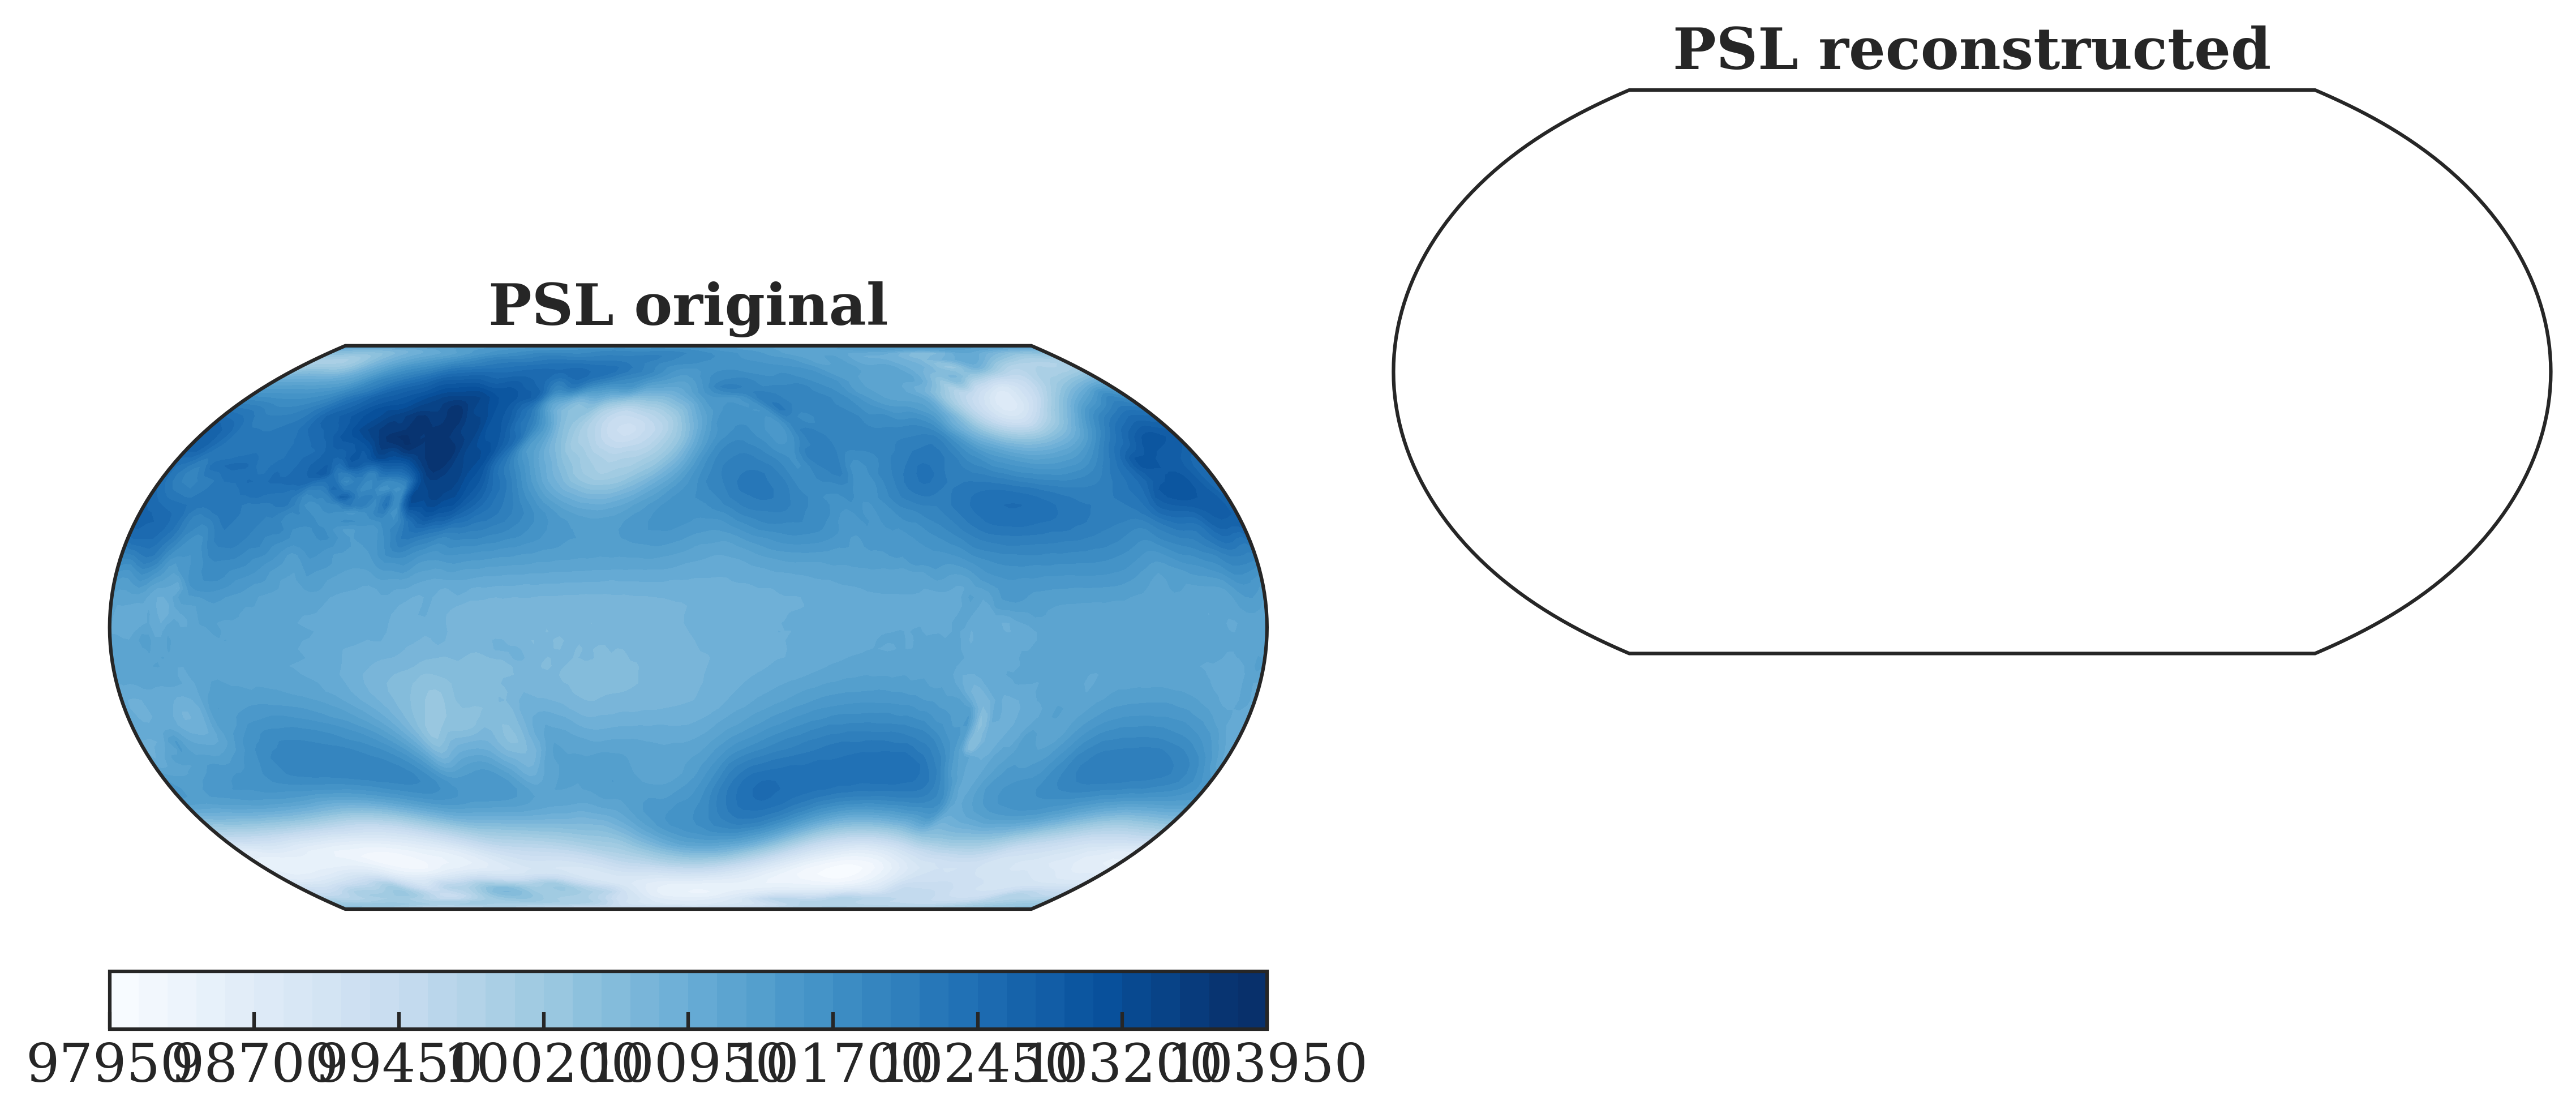

In [15]:
fig, axs = plt.subplots(
    1,
    2,
    figsize=(10, 5),
    subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=198)),
)

axs[0].set_title("PSL original")
plot_field(axs[0], data.isel(time=0)["psl"])

axs[1].set_title("PSL reconstructed")
plot_field(axs[1], y.isel(time=0)["psl"])